<a href="https://colab.research.google.com/github/rahim-dotAI/AI_Forex_Brain/blob/main/Another_copy_of_AI_Forex_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests beautifulsoup4 pandas numpy ta yfinance lightgbm joblib matplotlib alpha_vantage tqdm scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import os

save_path = '/content/drive/MyDrive/FX_AI/indicators'
combined_data = {}  # dictionary to hold all pairs and timeframes

if os.path.exists(save_path):
    files = glob.glob(os.path.join(save_path, '*.pkl'))
    for file in files:
        # Example filename: EURUSD_1h_2y_ind.pkl
        filename = os.path.basename(file).replace('_ind.pkl','')
        # Split into pair and timeframe
        pair, tf = filename.split('_', 1)
        if pair not in combined_data:
            combined_data[pair] = {}
        combined_data[pair][tf] = pd.read_pickle(file)
    print(f"Loaded saved data for {len(combined_data)} pairs from Google Drive.")
else:
    print("No saved data found, starting fresh.")

Loaded saved data for 0 pairs from Google Drive.


In [ ]:
import os

# Set your keys (only for this session)
os.environ['ALPHA_VANTAGE_KEY'] = 'IRHEYHESM3EW54DR'
os.environ['BROWSERLESS_TOKEN'] = '2St0qUktyKsA0Bsb5b510553885cae26942e44c26c0f19c3d'

# Test if they work
print("Alpha Vantage Key:", os.environ.get('ALPHA_VANTAGE_KEY'))
print("Browserless Token:", os.environ.get('BROWSERLESS_TOKEN'))




Alpha Vantage Key: IRHEYHESM3EW54DR
Browserless Token: 2St0qUktyKsA0Bsb5b510553885cae26942e44c26c0f19c3d


In [ ]:
import os
import pandas as pd
import requests
from datetime import datetime

# --- Set your Alpha Vantage key in Colab environment ---
# os.environ['ALPHA_VANTAGE_KEY'] = 'YOUR_ALPHA_VANTAGE_KEY'

def fetch_alpha_vantage_fx(pair, outputsize='compact'):
    """Fetch historical daily FX rates for a given currency pair from Alpha Vantage."""
    base_url = 'https://www.alphavantage.co/query'
    from_currency, to_currency = pair.split('/')
    params = {
        'function': 'FX_DAILY',
        'from_symbol': from_currency,
        'to_symbol': to_currency,
        'outputsize': outputsize,
        'datatype': 'json',
        'apikey': os.environ['ALPHA_VANTAGE_KEY']  # <-- fixed here
    }
    response = requests.get(base_url, params=params)
    data = response.json()

    if 'Time Series FX (Daily)' not in data:
        print(f"Failed to fetch {pair}: {data}")
        return None

    ts = data['Time Series FX (Daily)']
    df = pd.DataFrame(ts).T  # transpose
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df.rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        '4. close': 'close'
    }).astype(float)

    return df

# --- Fetch multiple pairs ---
pairs = ["EUR/USD", "GBP/USD", "USD/JPY", "AUD/USD"]
historical_data = {}

for pair in pairs:
    df = fetch_alpha_vantage_fx(pair)
    if df is not None:
        historical_data[pair] = df
        print(f"Fetched {pair}: {df.shape[0]} rows")
    else:
        print(f"Skipped {pair} due to error")

# Example: preview EUR/USD data
historical_data["EUR/USD"].head()


Fetched EUR/USD: 100 rows
Fetched GBP/USD: 100 rows
Fetched USD/JPY: 100 rows
Fetched AUD/USD: 100 rows


,open,high,low,close
2025-04-08,1.09112,1.09918,1.08881,1.09565
2025-04-09,1.09564,1.10952,1.09130,1.09503
2025-04-10,1.09497,1.12414,1.09426,1.11888
2025-04-11,1.11918,1.14736,1.11918,1.13586
2025-04-14,1.13177,1.14246,1.12956,1.13522


In [ ]:
import yfinance as yf
import pandas as pd

# FX pairs to fetch
fx_pairs = ["EUR/USD", "GBP/USD", "USD/JPY", "AUD/USD"]

# Timeframes: (interval, period)
timeframes = {
    "1m_7d": ("1m", "7d"),
    "5m_1mo": ("5m", "1mo"),
    "15m_60d": ("15m", "60d"),
    "1h_2y": ("1h", "2y"),
    "1d_5y": ("1d", "5y")
}

# Dictionary to store all data
yfinance_data = {}

for pair in fx_pairs:
    yfinance_data[pair] = {}
    symbol = pair.replace("/", "") + "=X"
    for tf_name, (interval, period) in timeframes.items():
        try:
            df = yf.download(
                symbol,
                period=period,
                interval=interval,
                progress=False,
                auto_adjust=False  # use raw prices for AI learning
            )
            if df.empty:
                print(f"Skipped {pair} {tf_name}: No data")
                continue
            # Keep only OHLC columns and standardize column names
            df = df[['Open', 'High', 'Low', 'Close']]
            df.columns = ['open', 'high', 'low', 'close']
            df.index = pd.to_datetime(df.index)
            yfinance_data[pair][tf_name] = df
            print(f"Fetched {pair} {tf_name}: {len(df)} rows")
        except Exception as e:
            print(f"Failed to fetch {pair} {tf_name}: {e}")

# Example: preview EUR/USD 15m/60d data
if "15m_60d" in yfinance_data["EUR/USD"]:
    display(yfinance_data["EUR/USD"]["15m_60d"].head())


Fetched EUR/USD 1m_7d: 9857 rows
Fetched EUR/USD 5m_1mo: 5974 rows
Fetched EUR/USD 15m_60d: 5685 rows
Fetched EUR/USD 1h_2y: 12334 rows
Fetched EUR/USD 1d_5y: 1302 rows
Fetched GBP/USD 1m_7d: 9856 rows
Fetched GBP/USD 5m_1mo: 5974 rows
Fetched GBP/USD 15m_60d: 5686 rows
Fetched GBP/USD 1h_2y: 12334 rows
Fetched GBP/USD 1d_5y: 1302 rows
Fetched USD/JPY 1m_7d: 9805 rows
Fetched USD/JPY 5m_1mo: 5950 rows
Fetched USD/JPY 15m_60d: 5663 rows
Fetched USD/JPY 1h_2y: 12266 rows
Fetched USD/JPY 1d_5y: 1302 rows
Fetched AUD/USD 1m_7d: 5561 rows
Fetched AUD/USD 5m_1mo: 5971 rows
Fetched AUD/USD 15m_60d: 5685 rows
Fetched AUD/USD 1h_2y: 12404 rows
Fetched AUD/USD 1d_5y: 1302 rows


,open,high,low,close
Datetime,,,,
2025-06-02 23:00:00+00:00,1.144820,1.145213,1.144820,1.145213
2025-06-02 23:15:00+00:00,1.145344,1.145607,1.145213,1.145344
2025-06-02 23:30:00+00:00,1.145344,1.145607,1.145344,1.145607
2025-06-02 23:45:00+00:00,1.145738,1.145738,1.145607,1.145738
2025-06-03 00:00:00+00:00,1.145607,1.145738,1.144820,1.144820


In [ ]:
import pandas as pd

def combine_fx_data(av_df, yf_df):
    """
    Combine Alpha Vantage and yfinance DataFrames for same FX pair
    """
    if av_df is None and yf_df is None:
        return None
    elif av_df is None:
        return yf_df
    elif yf_df is None:
        return av_df

    # Make indices compatible
    if av_df.index.tz is not None:
        av_df.index = av_df.index.tz_convert(None)
    if yf_df.index.tz is not None:
        yf_df.index = yf_df.index.tz_convert(None)

    # Align on datetime index
    combined = pd.merge(av_df, yf_df, left_index=True, right_index=True, how='outer', suffixes=('_av', '_yf'))

    # Average the values where both sources exist
    for col in ['open', 'high', 'low', 'close']:
        combined[col] = combined[[f"{col}_av", f"{col}_yf"]].mean(axis=1)

    # Keep only combined columns
    combined = combined[['open', 'high', 'low', 'close']].sort_index()
    return combined

# --- Combine all pairs and timeframes ---
combined_data = {}
pairs = ["EUR/USD","GBP/USD","USD/JPY","AUD/USD"]
timeframes = ["1m_7d", "5m_1mo", "15m_60d", "1h_2y", "1d_5y"]

for pair in pairs:
    combined_data[pair] = {}
    av_df = historical_data.get(pair)

    for tf in timeframes:
        yf_df = yfinance_data.get(pair, {}).get(tf)
        combined_data[pair][tf] = combine_fx_data(av_df, yf_df)
        if combined_data[pair][tf] is not None:
            print(f"Combined {pair} {tf}: {combined_data[pair][tf].shape[0]} rows")
        else:
            print(f"No data for {pair} {tf}")


# --- Create folder for saving ---
save_path = '/content/drive/MyDrive/FX_AI/combined_data'
os.makedirs(save_path, exist_ok=True)

# --- Save each pair and timeframe ---
for pair, tfs in combined_data.items():
    for tf, df in tfs.items():
        if df is not None:
            filename = f"{pair.replace('/','')}_{tf}.pkl"
            df.to_pickle(os.path.join(save_path, filename))
            print(f"Saved {pair} {tf} -> {filename}")


Combined EUR/USD 1m_7d: 9950 rows
Combined EUR/USD 5m_1mo: 6053 rows
Combined EUR/USD 15m_60d: 5725 rows
Combined EUR/USD 1h_2y: 12334 rows
Combined EUR/USD 1d_5y: 1304 rows
Combined GBP/USD 1m_7d: 9949 rows
Combined GBP/USD 5m_1mo: 6053 rows
Combined GBP/USD 15m_60d: 5726 rows
Combined GBP/USD 1h_2y: 12334 rows
Combined GBP/USD 1d_5y: 1304 rows
Combined USD/JPY 1m_7d: 9898 rows
Combined USD/JPY 5m_1mo: 6029 rows
Combined USD/JPY 15m_60d: 5703 rows
Combined USD/JPY 1h_2y: 12266 rows
Combined USD/JPY 1d_5y: 1304 rows
Combined AUD/USD 1m_7d: 5659 rows
Combined AUD/USD 5m_1mo: 6050 rows
Combined AUD/USD 15m_60d: 5725 rows
Combined AUD/USD 1h_2y: 12404 rows
Combined AUD/USD 1d_5y: 1304 rows
Saved EUR/USD 1m_7d -> EURUSD_1m_7d.pkl
Saved EUR/USD 5m_1mo -> EURUSD_5m_1mo.pkl
Saved EUR/USD 15m_60d -> EURUSD_15m_60d.pkl
Saved EUR/USD 1h_2y -> EURUSD_1h_2y.pkl
Saved EUR/USD 1d_5y -> EURUSD_1d_5y.pkl
Saved GBP/USD 1m_7d -> GBPUSD_1m_7d.pkl
Saved GBP/USD 5m_1mo -> GBPUSD_5m_1mo.pkl
Saved GBP/USD 15

In [ ]:
import os
import requests
import re

def fetch_live_rate(pair):
    """
    Fetch live FX rate from X-Rates using Browserless (Python version of your Node.js code)
    """
    from_currency, to_currency = pair.split('/')
    browserless_token = os.environ.get('BROWSERLESS_TOKEN')
    if not browserless_token:
        raise ValueError("Set BROWSERLESS_TOKEN in your environment variables")

    url = f"https://production-sfo.browserless.io/content?token={browserless_token}"
    payload = {"url": f"https://www.x-rates.com/calculator/?from={from_currency}&to={to_currency}&amount=1"}

    try:
        res = requests.post(url, json=payload)
        # Regex to extract the FX value
        match = re.search(r'ccOutputRslt[^>]*>([\d,.]+)', res.text)
        return float(match.group(1).replace(',', '')) if match else 0
    except Exception as e:
        print(f"Failed to fetch {pair}: {e}")
        return 0

# --- Fetch live prices for all pairs ---
pairs = ["EUR/USD", "GBP/USD", "USD/JPY", "AUD/USD"]
live_prices = {pair: fetch_live_rate(pair) for pair in pairs}

for pair, price in live_prices.items():
    print(f"{pair}: {price}")


EUR/USD: 1.161
GBP/USD: 1.345
USD/JPY: 147.82
AUD/USD: 0.648


In [ ]:
# -----------------------------
# Imports
# -----------------------------
import os
import pandas as pd
import ta
from ta.momentum import WilliamsRIndicator
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import numpy as np

# -----------------------------
# Add Indicators Function
# -----------------------------
def add_all_indicators(df):
    if df is None or df.empty:
        return df
    df = df.copy()

    # -----------------------------
    # Trend Indicators
    # -----------------------------
    trend_indicators = {
        'SMA_10': lambda df: ta.trend.sma_indicator(df['close'], window=10),
        'SMA_50': lambda df: ta.trend.sma_indicator(df['close'], window=50),
        'SMA_200': lambda df: ta.trend.sma_indicator(df['close'], window=200),
        'EMA_10': lambda df: ta.trend.ema_indicator(df['close'], window=10),
        'EMA_50': lambda df: ta.trend.ema_indicator(df['close'], window=50),
        'EMA_200': lambda df: ta.trend.ema_indicator(df['close'], window=200),
        'MACD': lambda df: ta.trend.macd(df['close']),
        'MACD_signal': lambda df: ta.trend.macd_signal(df['close']),
        'ADX': lambda df: ta.trend.adx(df['high'], df['low'], df['close'], window=14)
    }

    # -----------------------------
    # Momentum Indicators
    # -----------------------------
    momentum_indicators = {
        'RSI_14': lambda df: ta.momentum.rsi(df['close'], window=14),
        'StochRSI': lambda df: ta.momentum.stochrsi(df['close'], window=14),
        'CCI': lambda df: ta.trend.cci(df['high'], df['low'], df['close'], window=20),
        'ROC': lambda df: ta.momentum.roc(df['close'], window=12),
        'Williams_%R': lambda df: WilliamsRIndicator(df['high'], df['low'], df['close'], lbp=14).williams_r()
    }

    # -----------------------------
    # Volatility Indicators
    # -----------------------------
    volatility_indicators = {
        'Bollinger_High': lambda df: ta.volatility.bollinger_hband(df['close'], window=20, window_dev=2),
        'Bollinger_Low': lambda df: ta.volatility.bollinger_lband(df['close'], window=20, window_dev=2),
        'ATR': lambda df: ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14),
        'STDDEV_20': lambda df: df['close'].rolling(window=20).std(),
    }

    # -----------------------------
    # Volume Indicators
    # -----------------------------
    volume_indicators = {}
    if 'volume' in df.columns:
        volume_indicators = {
            'OBV': lambda df: ta.volume.on_balance_volume(df['close'], df['volume']),
            'MFI': lambda df: ta.volume.money_flow_index(df['high'], df['low'], df['close'], df['volume'], window=14)
        }

    # Combine all indicators
    all_indicators = {**trend_indicators, **momentum_indicators, **volatility_indicators, **volume_indicators}

    # -----------------------------
    # Apply all indicators
    # -----------------------------
    for name, func in all_indicators.items():
        try:
            df[name] = func(df)
        except Exception as e:
            df[name] = np.nan
            print(f"Failed {name}: {e}")

    # -----------------------------
    # EMA/SMA Crossovers
    # -----------------------------
    try:
        df['EMA_10_cross_EMA_50'] = (df['EMA_10'] > df['EMA_50']).astype(int)
        df['EMA_50_cross_EMA_200'] = (df['EMA_50'] > df['EMA_200']).astype(int)
        df['SMA_10_cross_SMA_50'] = (df['SMA_10'] > df['SMA_50']).astype(int)
        df['SMA_50_cross_SMA_200'] = (df['SMA_50'] > df['SMA_200']).astype(int)
    except Exception as e:
        print(f"Failed crossover signals: {e}")

    # -----------------------------
    # Support/Resistance Levels
    # -----------------------------
    try:
        df['recent_high'] = df['high'].rolling(window=20).max()
        df['recent_low'] = df['low'].rolling(window=20).min()
        df['pivot_point'] = (df['high'] + df['low'] + df['close']) / 3
        df['support_1'] = 2 * df['pivot_point'] - df['high']
        df['resistance_1'] = 2 * df['pivot_point'] - df['low']
    except Exception as e:
        print(f"Failed support/resistance: {e}")

    # -----------------------------
    # Replace inf/NaN values before normalization
    # -----------------------------
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.ffill(inplace=True)   # fixed warning
    df.bfill(inplace=True)   # fixed warning
    df.fillna(0, inplace=True)

    # -----------------------------
    # Normalize numeric columns safely
    # -----------------------------
    try:
        scaler = MinMaxScaler()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    except Exception as e:
        print(f"Failed normalization: {e}")

    # -----------------------------
    # Signal Strength Scoring (safe)
    # -----------------------------
    try:
        df['long_score'] = (
            df.get('EMA_10_cross_EMA_50', pd.Series(0, index=df.index)).fillna(0) +
            df.get('EMA_50_cross_EMA_200', pd.Series(0, index=df.index)).fillna(0) +
            df.get('SMA_10_cross_SMA_50', pd.Series(0, index=df.index)).fillna(0) * 0.5 +
            df.get('SMA_50_cross_SMA_200', pd.Series(0, index=df.index)).fillna(0) * 0.5 +
            df.get('ADX', pd.Series(0, index=df.index)).fillna(0) +
            df.get('RSI_14', pd.Series(0, index=df.index)).fillna(0)
        )
        df['short_score'] = (
            (1 - df.get('EMA_10_cross_EMA_50', pd.Series(0, index=df.index)).fillna(0)) +
            (1 - df.get('EMA_50_cross_EMA_200', pd.Series(0, index=df.index)).fillna(0)) +
            (1 - df.get('SMA_10_cross_SMA_50', pd.Series(0, index=df.index)).fillna(0)) * 0.5 +
            (1 - df.get('SMA_50_cross_SMA_200', pd.Series(0, index=df.index)).fillna(0)) * 0.5 +
            (1 - df.get('ADX', pd.Series(0, index=df.index)).fillna(0)) +
            (1 - df.get('RSI_14', pd.Series(0, index=df.index)).fillna(0))
        )
    except Exception as e:
        print(f"Failed scoring: {e}")

    return df


# -----------------------------
# Apply to all pairs/timeframes and save
# -----------------------------
save_path = '/content/drive/MyDrive/FX_AI/indicators'
os.makedirs(save_path, exist_ok=True)

for pair, tfs in tqdm(combined_data.items(), desc="Processing Pairs"):
    for tf, df in tfs.items():
        if df is not None:
            df = add_all_indicators(df)
            combined_data[pair][tf] = df
            filename = f"{pair.replace('/','')}_{tf}_ind.pkl"
            df.to_pickle(os.path.join(save_path, filename))

print("All indicator data saved to Google Drive.")


Processing Pairs: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]

All indicator data saved to Google Drive.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import os
import joblib
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------------
# 1️⃣ Rule-Based Signal Generator
# -----------------------------
def generate_rule_signal(df):
    df = df.copy()
    df['rule_signal'] = 0

    # EMA + RSI
    df['ema_rsi_signal'] = 0
    df.loc[(df['EMA_10'] > df['EMA_50']) & (df['RSI_14'] < 70), 'ema_rsi_signal'] = 1
    df.loc[(df['EMA_10'] < df['EMA_50']) & (df['RSI_14'] > 30), 'ema_rsi_signal'] = -1

    # Bollinger
    df['bollinger_signal'] = 0
    df.loc[df['close'] < df['Bollinger_Low'], 'bollinger_signal'] = 1
    df.loc[df['close'] > df['Bollinger_High'], 'bollinger_signal'] = -1

    # Weighted sum
    df['rule_signal'] = df['ema_rsi_signal'] + df['bollinger_signal']

    # ADX filter
    df.loc[df['ADX'] < 20, 'rule_signal'] = 0

    # Scale to -1,0,1
    df['rule_signal'] = df['rule_signal'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
    return df

# -----------------------------
# 2️⃣ Precompute Lag Features
# -----------------------------
def add_lag_features(df, columns, lags=[1,2,3]):
    df = df.copy()
    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# -----------------------------
# 3️⃣ Incremental ML Model Trainer with Caching
# -----------------------------
def train_stacked_model_incremental(df, model_path, feature_cols=None, timeframe='1m'):
    df = df.dropna().copy()
    if feature_cols is None:
        feature_cols = ['SMA_10','SMA_50','EMA_10','EMA_50','RSI_14','MACD','ADX','ATR']

    df = add_lag_features(df, ['close','RSI_14','MACD'])

    X = df[feature_cols + [c for c in df.columns if '_lag' in c]]
    y = (df['close'].shift(-1) > df['close']).astype(int)

    if os.path.exists(model_path):
        stacking_model, last_index = joblib.load(model_path)

        if last_index >= len(df) - 1:
            df['ml_confidence'] = stacking_model.predict_proba(X)[:,1]
        else:
            # Incremental retrain only on new data
            X_new = X.iloc[last_index+1:]
            y_new = y.iloc[last_index+1:]
            if len(X_new) > 0:
                stacking_model.fit(X_new, y_new)
            df['ml_confidence'] = stacking_model.predict_proba(X)[:,1]

        last_index = len(df) - 1
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump((stacking_model, last_index), model_path)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, n_jobs=-1, random_state=42)
        lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.05, n_jobs=-1, random_state=42)
        stacking_model = StackingClassifier(
            estimators=[('rf', rf_model), ('lgb', lgb_model)],
            final_estimator=LogisticRegression(),
            n_jobs=-1
        )
        stacking_model.fit(X_train, y_train)
        acc = accuracy_score(y_test, stacking_model.predict(X_test))
        print(f"Trained new model. Accuracy: {acc:.2f}")
        last_index = len(df) - 1
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump((stacking_model, last_index), model_path)
        df['ml_confidence'] = stacking_model.predict_proba(X)[:,1]

    df['ml_signal'] = 0
    df.loc[df['ml_confidence'] > 0.55, 'ml_signal'] = 1
    df.loc[df['ml_confidence'] < 0.45, 'ml_signal'] = -1

    return df, stacking_model

# -----------------------------
# 4️⃣ Hybrid Signal with Dynamic ML Weight per TF
# -----------------------------
def hybrid_signal_improved(df, timeframe, base_ml_weight=0.6, sensitivity=1.0):
    df = df.copy()
    tf_map = {'1m':0.5,'5m':0.55,'15m':0.58,'1h':0.62,'1d':0.65}
    ml_weight = tf_map.get(timeframe.split('_')[0], base_ml_weight) * sensitivity
    rule_weight = 1 - ml_weight

    df['rule_scaled'] = (df['rule_signal'] + 1)/2
    df['hybrid_score'] = df['ml_confidence']*ml_weight + df['rule_scaled']*rule_weight

    vol = df['close'].pct_change().rolling(14).std()
    upper_thresh = 0.5 + vol/(2*vol.max())
    lower_thresh = 0.5 - vol/(2*vol.max())

    df['hybrid_signal'] = 0
    df.loc[df['hybrid_score'] >= upper_thresh, 'hybrid_signal'] = 1
    df.loc[df['hybrid_score'] <= lower_thresh, 'hybrid_signal'] = -1

    return df

# -----------------------------
# 5️⃣ Parallel Processing per Pair/TF
# -----------------------------
def process_pair_tf(pair, tf, df, model_dir):
    df = generate_rule_signal(df)
    model_path = os.path.join(model_dir, f"{pair.replace('/','')}_{tf}_stacked.pkl")
    df, model = train_stacked_model_incremental(df, model_path, timeframe=tf)
    df = hybrid_signal_improved(df, tf)
    n_long = (df['hybrid_signal']==1).sum()
    n_short = (df['hybrid_signal']==-1).sum()
    n_hold = (df['hybrid_signal']==0).sum()
    print(f"Hybrid signals for {pair} {tf}: Long={n_long}, Short={n_short}, Hold={n_hold}")
    return pair, tf, df, model

def generate_hybrid_signals_parallel(combined_data, model_dir='/content/drive/MyDrive/FX_AI/models', max_workers=6):
    hybrid_models = {}
    futures = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for pair, tfs in combined_data.items():
            hybrid_models[pair] = {}
            for tf, df in tfs.items():
                futures.append(executor.submit(process_pair_tf, pair, tf, df, model_dir))
        for future in as_completed(futures):
            pair, tf, df, model = future.result()
            combined_data[pair][tf] = df
            hybrid_models[pair][tf] = model
    return combined_data, hybrid_models

# -----------------------------
# 6️⃣ Run the pipeline
# -----------------------------
# combined_data = {
#     'EUR/USD': {'1m_7d': eurusd_1m_df, '5m_1mo': eurusd_5m_df, ...},
#     'GBP/USD': {'1m_7d': gbpusd_1m_df, '5m_1mo': gbpusd_5m_df, ...},
# }

combined_data, hybrid_models = generate_hybrid_signals_parallel(
    combined_data,
    model_dir='/content/drive/MyDrive/FX_AI/models',
    max_workers=6
)


Hybrid signals for EUR/USD 1d_5y: Long=1, Short=13, Hold=1275
Hybrid signals for EUR/USD 15m_60d: Long=5, Short=5301, Hold=404
Hybrid signals for EUR/USD 5m_1mo: Long=0, Short=5908, Hold=130
Hybrid signals for GBP/USD 1m_7d: Long=0, Short=9735, Hold=199
Hybrid signals for EUR/USD 1m_7d: Long=0, Short=9874, Hold=61
Hybrid signals for EUR/USD 1h_2y: Long=0, Short=11764, Hold=555
Hybrid signals for GBP/USD 5m_1mo: Long=531, Short=985, Hold=4522
Hybrid signals for GBP/USD 15m_60d: Long=323, Short=181, Hold=5207
Hybrid signals for GBP/USD 1d_5y: Long=418, Short=518, Hold=353
Hybrid signals for GBP/USD 1h_2y: Long=2675, Short=3501, Hold=6143
Hybrid signals for USD/JPY 5m_1mo: Long=694, Short=2464, Hold=2856
Hybrid signals for USD/JPY 1m_7d: Long=215, Short=5842, Hold=3826
Hybrid signals for USD/JPY 1d_5y: Long=650, Short=26, Hold=616
Hybrid signals for USD/JPY 15m_60d: Long=75, Short=0, Hold=5613
Hybrid signals for USD/JPY 1h_2y: Long=6729, Short=2903, Hold=2622
Hybrid signals for AUD/USD 5m

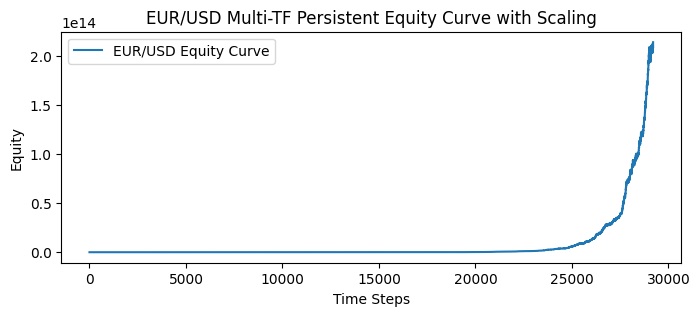

EUR/USD: Total PnL=213850790186198.41, Win Rate=44.82%, Max DD=15392167745832.41


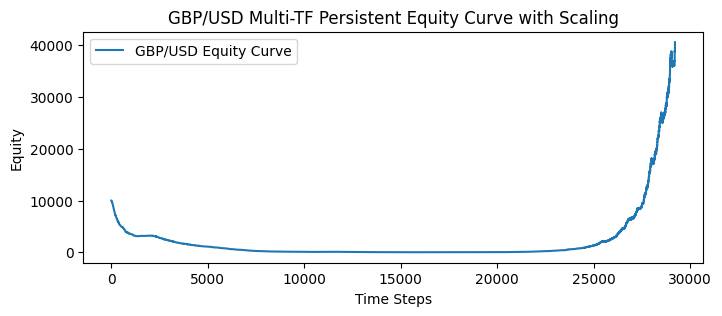

GBP/USD: Total PnL=30611.30, Win Rate=34.85%, Max DD=9987.86


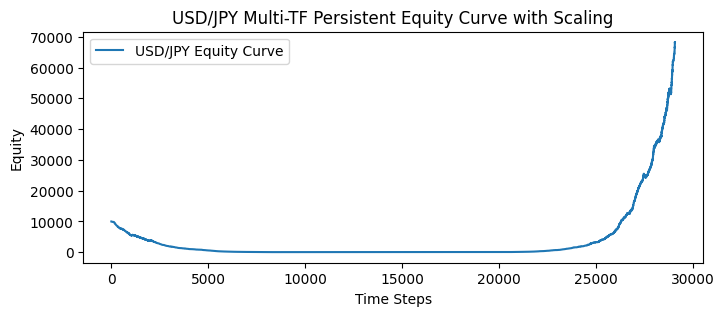

USD/JPY: Total PnL=58252.65, Win Rate=36.31%, Max DD=10013.32


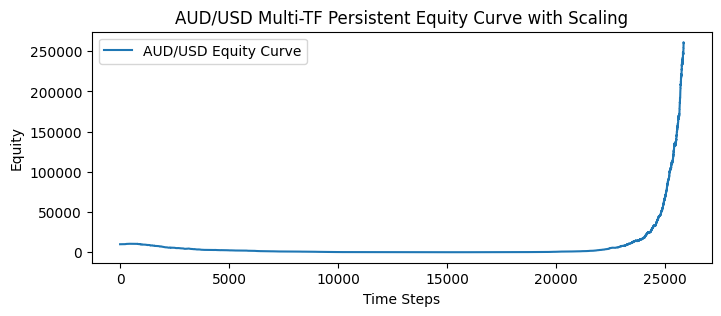

AUD/USD: Total PnL=250181.89, Win Rate=36.63%, Max DD=10503.49


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Generate Trades from Hybrid Signals per TF
# -----------------------------
def generate_trades(df):
    """
    Convert hybrid_signal to trade signals for processing.
    """
    trades = []
    for idx, row in df.iterrows():
        if row['hybrid_signal'] == 1:
            trades.append({'time': idx, 'type': 'Long', 'price': row['close']})
        elif row['hybrid_signal'] == -1:
            trades.append({'time': idx, 'type': 'Short', 'price': row['close']})
    return trades

# -----------------------------
# 2️⃣ Multi-TF Backtest with Persistent Positions & Partial Scaling
# -----------------------------
def multi_tf_backtest_scaling(combined_data, capital=10000, base_risk_per_trade=0.01,
                              sl_pips=0.001, tp_pips=0.002, transaction_cost=0.0001,
                              tf_weights=None, max_scale=3):
    """
    Multi-timeframe backtest with persistent positions and partial scaling.
    Positions can scale up to max_scale depending on aggregated signal strength.
    """
    backtest_results = {}

    for pair, tfs in combined_data.items():
        # Align time indices across all timeframes
        all_times = sorted(set().union(*[df.index for df in tfs.values()]))
        equity = [capital]
        current_capital = capital
        open_positions = []
        trade_history = []

        # Calculate default weights if none provided for this pair
        current_tf_weights = tf_weights.get(pair) if tf_weights else None
        if current_tf_weights is None:
            n_tfs = len(tfs)
            current_tf_weights = {tf: 1/n_tfs for tf in tfs.keys()}


        for time in all_times:
            # Aggregate signals across TFs
            agg_signal = 0
            for tf, df in tfs.items():
                if time in df.index:
                    weight = current_tf_weights.get(tf, 1/len(tfs)) # Use current_tf_weights
                    agg_signal += df.loc[time, 'hybrid_signal'] * weight

            # Determine trade type
            position_type = None
            scale_factor = 0
            if agg_signal > 0:
                position_type = 'Long'
                scale_factor = min(agg_signal, max_scale)
            elif agg_signal < 0:
                position_type = 'Short'
                scale_factor = min(-agg_signal, max_scale)

            # Open new trade if signal exists
            if position_type is not None and scale_factor > 0:
                # Calculate dynamic position size based on aggregated signal
                position_size = current_capital * base_risk_per_trade * scale_factor / sl_pips
                avg_price = np.mean([df.loc[time, 'close'] for df in tfs.values() if time in df.index])
                open_positions.append({
                    'type': position_type,
                    'entry_price': avg_price,
                    'size': position_size,
                    'sl': avg_price - sl_pips if position_type=='Long' else avg_price + sl_pips,
                    'tp': avg_price + tp_pips if position_type=='Long' else avg_price - tp_pips,
                    'open_time': time,
                    'scale': scale_factor
                })

            # Compute average price across TFs for current bar
            next_prices = [df.loc[time, 'close'] for df in tfs.values() if time in df.index]
            if len(next_prices) == 0:
                equity.append(current_capital)
                continue
            current_price = np.mean(next_prices)

            # Update open positions
            still_open = []
            for pos in open_positions:
                pnl = 0
                closed = False
                # Check TP/SL
                if pos['type'] == 'Long':
                    if current_price >= pos['tp']:
                        pnl = pos['size'] * tp_pips - transaction_cost
                        closed = True
                    elif current_price <= pos['sl']:
                        pnl = -pos['size'] * sl_pips - transaction_cost
                        closed = True
                elif pos['type'] == 'Short':
                    if current_price <= pos['tp']:
                        pnl = pos['size'] * tp_pips - transaction_cost
                        closed = True
                    elif current_price >= pos['sl']:
                        pnl = -pos['size'] * sl_pips - transaction_cost
                        closed = True

                if closed:
                    current_capital += pnl
                    trade_history.append({
                        'time': time,
                        'position': pos['type'],
                        'entry_price': pos['entry_price'],
                        'exit_price': current_price,
                        'pnl': pnl,
                        'capital': current_capital,
                        'scale': pos['scale']
                    })
                else:
                    still_open.append(pos)

            open_positions = still_open
            equity.append(current_capital)

        # Store results
        backtest_results[pair] = {
            'equity_curve': equity,
            'trades': trade_history,
            'total_pnl': current_capital - capital,
            'max_drawdown': np.max(np.maximum.accumulate(equity) - equity),
            'win_rate': np.sum([t['pnl']>0 for t in trade_history]) / len(trade_history) if len(trade_history)>0 else 0
        }

        # Plot equity curve
        plt.figure(figsize=(8,3))
        plt.plot(backtest_results[pair]['equity_curve'], label=f'{pair} Equity Curve')
        plt.title(f'{pair} Multi-TF Persistent Equity Curve with Scaling')
        plt.xlabel('Time Steps')
        plt.ylabel('Equity')
        plt.legend()
        plt.show()

        print(f"{pair}: Total PnL={backtest_results[pair]['total_pnl']:.2f}, "
              f"Win Rate={backtest_results[pair]['win_rate']*100:.2f}%, "
              f"Max DD={backtest_results[pair]['max_drawdown']:.2f}")

    return backtest_results

# -----------------------------
# 3️⃣ Run Multi-TF Persistent Backtest with Partial Scaling
# -----------------------------
backtest_results = multi_tf_backtest_scaling(
    combined_data,
    capital=10000,
    base_risk_per_trade=0.01,
    sl_pips=0.001,
    tp_pips=0.002,
    transaction_cost=0.0001,
    max_scale=3  # Scale trades up to 3x based on aggregated signal
)